In [1]:
import pandas as pd

airbnb_url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/airbnb-listings/exports/csv?lang=en&facet=facet(name%3D%22host_verifications%22%2C%20disjunctive%3Dtrue)&facet=facet(name%3D%22amenities%22%2C%20disjunctive%3Dtrue)&facet=facet(name%3D%22features%22%2C%20disjunctive%3Dtrue)&qv1=(Madrid)&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
airbnb = pd.read_csv(airbnb_url, sep=";")
airbnb.shape

(14780, 89)

# **1. Data cleaning and preprocessing**

In [2]:
# Filter Madrid samples
madrid_mask = [True if "madrid" in street.lower() and country == "Spain" else False
     for street, country in zip(airbnb["Street"], airbnb["Country"])]
madrid = airbnb[madrid_mask]
madrid.shape

(13268, 89)

### 1.1. Train-Validation-Test split

In [3]:
from sklearn.model_selection import train_test_split

# Split data into training, validation and testing sets
mad_train, mad_test = train_test_split(madrid, test_size=0.2, random_state=0, shuffle=True)
mad_train, mad_val = train_test_split(mad_train, test_size=0.15, random_state=0, shuffle=True)

print(f"Train shape: {mad_train.shape}")
print(f"Validation shape: {mad_val.shape}")
print(f"Test shape: {mad_test.shape}")

Train shape: (9021, 89)
Validation shape: (1593, 89)
Test shape: (2654, 89)


### 1.2. Feature selection

In [4]:
# Keep columns
columns = ['Price', 'Picture Url', 'Host Response Time', 'Host Response Rate',
           'Host Acceptance Rate', 'Latitude', 'Longitude', 'Property Type',
           'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
           'Amenities', 'Square Feet', 'Security Deposit', 'Cleaning Fee',
           'Guests Included', 'Extra People', 'Minimum Nights',
           'Review Scores Rating', 'License', 'Cancellation Policy']

mad_train = mad_train[columns]
mad_val = mad_val[columns]
mad_test = mad_test[columns]

### 1.3. Outliers and missing values

In [5]:
# Remove outliers
mad_train = mad_train[mad_train["Bathrooms"] >= 1].copy()
mad_val = mad_val[mad_val["Bathrooms"] >= 1].copy()
mad_test = mad_test[mad_test["Bathrooms"] >= 1].copy()

# Replace missing values in Security Deposit and Cleaning Fee
mad_train["Security Deposit"].fillna(0, inplace=True)
mad_train["Cleaning Fee"].fillna(0, inplace=True)

mad_val["Security Deposit"].fillna(0, inplace=True)
mad_val["Cleaning Fee"].fillna(0, inplace=True)

mad_test["Security Deposit"].fillna(0, inplace=True)
mad_test["Cleaning Fee"].fillna(0, inplace=True)

# Remove missing values
na_mask = mad_train.isna().sum() / mad_train.shape[0] > 0.9
mad_train.drop(mad_train.columns[na_mask], axis=1, inplace=True)
mad_val.drop(mad_val.columns[na_mask], axis=1, inplace=True)
mad_test.drop(mad_test.columns[na_mask], axis=1, inplace=True)

mad_train.dropna(inplace=True)
mad_val.dropna(inplace=True)
mad_test.dropna(inplace=True)

print(f"Train shape: {mad_train.shape}")
print(f"Validation shape: {mad_val.shape}")
print(f"Test shape: {mad_test.shape}")

Train shape: (6503, 21)
Validation shape: (1135, 21)
Test shape: (1962, 21)


### 1.4. Encoding

In [6]:
import numpy as np

dataframes = [mad_train, mad_val, mad_test]
for df in dataframes:
  # Property-type dummy encoding
  df["proptype_apartment"] = np.where(df["Property Type"] == "Apartment", 1, 0)

  # Bed-type dummy encoding
  df["bedtype_realbed"] = np.where(df["Bed Type"] == "Real Bed", 1, 0)

  # Drop Property-Type and Bed-Type columns
  df.drop(["Property Type", "Bed Type"], axis=1, inplace=True)

In [7]:
from sklearn.preprocessing import LabelEncoder

# Host-Response-Time label encoding:
# "a few days or more", "within a day", "within a few hours", "within an hour"
le_responsetime = LabelEncoder().fit(mad_train["Host Response Time"])

# Cancellation-Policy label encoding:
# "flexible", "moderate", "strict", "super_strict"
superstrict = ["super_strict_30", "super_strict_60"]
for df in dataframes:
  superstrict_mask = df["Cancellation Policy"].isin(superstrict)
  df.loc[superstrict_mask, "Cancellation Policy"] = "super_strict"
le_cancelpolicy = LabelEncoder().fit(mad_train["Cancellation Policy"])

# Room-Type label encoding:
# "Entire home/apt", "Private room", "Shared Room"
le_roomtype = LabelEncoder().fit(mad_train["Room Type"])

for df in dataframes:
  df["Host Response Time"] = le_responsetime.transform(df["Host Response Time"])
  df["Cancellation Policy"] = le_cancelpolicy.transform(df["Cancellation Policy"])
  df["Room Type"] = le_roomtype.transform(df["Room Type"])

In [8]:
# Amenities
amenities = {"heating": "Heating",
             "tv": "TV",
             "elevator": "Elevator in building",
             "aircon": "Air conditioning"
             }

for df in dataframes:
  # Number of amenities
  df["n_amenities"] = df["Amenities"].map(lambda s: len(s.split(",")))

  # Main-amenities dummy encoding
  for k, v in amenities.items():
    df[k] = df["Amenities"].map(lambda s: 1 if(v in s.split(",")) else 0)

  # Drop Amenities column
  df.drop(["Amenities"], axis=1, inplace=True)

In [9]:
!pip install utm

In [10]:
import utm

# Plaza Puerta del Sol, Madrid coordinates
longitude0 = -3.7034
latitude0 = 40.4167

# Project latitutude, logitude coordinates into x-y plane
x0, y0, _, _ = utm.from_latlon(latitude0, longitude0)
for df in dataframes:
  x, y, _, _ = utm.from_latlon(df["Latitude"].values, df["Longitude"].values)

  # Distance to Madrid center and cardinal directions
  df["distance"] = np.sqrt((x - x0)**2 + (y - y0)**2)
  df["north"] = (y >= y0) * 1
  df["east"] = (x >= x0) * 1

  # Drop Latitude and Longitude columns
  df.drop(["Latitude", "Longitude"], axis=1, inplace=True)

In [11]:
mad_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6503 entries, 10043 to 2105
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 6503 non-null   float64
 1   Picture Url           6503 non-null   object 
 2   Host Response Time    6503 non-null   int64  
 3   Host Response Rate    6503 non-null   float64
 4   Room Type             6503 non-null   int64  
 5   Accommodates          6503 non-null   int64  
 6   Bathrooms             6503 non-null   float64
 7   Bedrooms              6503 non-null   float64
 8   Beds                  6503 non-null   float64
 9   Security Deposit      6503 non-null   float64
 10  Cleaning Fee          6503 non-null   float64
 11  Guests Included       6503 non-null   int64  
 12  Extra People          6503 non-null   int64  
 13  Minimum Nights        6503 non-null   int64  
 14  Review Scores Rating  6503 non-null   float64
 15  Cancellation Poli

### 1.5. Download images and data standardisation

In [ ]:
import cv2
import imageio.v3 as io
from tqdm import tqdm
from typing import Optional

def download_images(paths: list,
                    canvas: tuple = (128, 128),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=np.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

In [ ]:
img_shape = (128, 128)
X_img_train, idxs_train = download_images(mad_train["Picture Url"], canvas=img_shape)
X_img_train = X_img_train.astype("float32") / 255.
print(X_img_train.shape)

X_img_val, idxs_val = download_images(mad_val["Picture Url"], canvas=img_shape)
X_img_val = X_img_val.astype("float32") / 255.
print(X_img_val.shape)

X_img_test, idxs_test = download_images(mad_test["Picture Url"], canvas=img_shape)
X_img_test = X_img_test.astype("float32") / 255.
print(X_img_test.shape)

In [ ]:
X_tab_train = mad_train.drop(["Price", "Picture Url"], axis=1).values[idxs_train, :].astype("float32")
y_train = mad_train["Price"].values[idxs_train].astype("float32")

X_tab_val = mad_val.drop(["Price", "Picture Url"], axis=1).values[idxs_val, :].astype("float32")
y_val = mad_val["Price"].values[idxs_val].astype("float32")

X_tab_test = mad_test.drop(["Price", "Picture Url"], axis=1).values[idxs_test, :].astype("float32")
y_test = mad_test["Price"].values[idxs_test].astype("float32")

In [ ]:
from sklearn.preprocessing import StandardScaler

xscaler = StandardScaler()
X_tab_train = xscaler.fit_transform(X_tab_train)
X_tab_val = xscaler.transform(X_tab_val)
X_tab_test = xscaler.transform(X_tab_test)

### 1.6. Save clean and preprocessed data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir -p /content/drive/MyDrive/airbnb/data

In [ ]:
base_path = "/content/drive/MyDrive/airbnb/data/"
np.save(base_path + "img.npy", np.array([X_img_train, X_img_val, X_img_test], dtype=object))
np.save(base_path + "tab.npy", np.array([X_tab_train, X_tab_val, X_tab_test], dtype=object))
np.save(base_path + "tag.npy", np.array([y_train, y_val, y_test], dtype=object))



---



### 1.7. Load datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%ls -l /content/drive/MyDrive/airbnb/data

total 1844139
-rw------- 1 root root 1887437270 Jul 17 18:11 img.npy
-rw------- 1 root root     922055 Jul 17 18:11 tab.npy
-rw------- 1 root root      38849 Jul 17 18:11 tag.npy


In [3]:
import numpy as np

base_path = "/content/drive/MyDrive/airbnb/data/"
X_img_train, X_img_val, X_img_test = np.load(base_path + "img.npy", allow_pickle=True)
X_tab_train, X_tab_val, X_tab_test = np.load(base_path + "tab.npy", allow_pickle=True)
y_train, y_val, y_test = np.load(base_path + "tag.npy", allow_pickle=True)

### 1.8. Define number of tag classes

In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

def set_classes(y_train, y_val, y_test, n_classes=0, scale=False):
  if n_classes:
    p = np.linspace(1 / n_classes, 1, n_classes)
    quantiles = np.quantile(y_train, p)

    q_min = 0
    for i, q in enumerate(quantiles):
      y_train[(q_min < y_train) & (y_train <= q)] = i
      y_val[(q_min < y_val) & (y_val <= q)] = i
      y_test[(q_min <  y_test) & (y_test <= q)] = i
      q_min = q

    y_train = to_categorical(y_train, n_classes)
    y_val = to_categorical(y_val, n_classes)
    y_test = to_categorical(y_test, n_classes)

  scaler = None
  if scale:
    scaler = MinMaxScaler()
    y_train = scaler.fit_transform(y_train)
    y_val = scaler.transform(y_val)
    y_test = scaler.transform(test)

  return y_train, y_val, y_test, scaler

In [5]:
n_classes = 3
Y_train, Y_val, Y_test, _ = set_classes(y_train, y_val, y_test, n_classes=n_classes)

# **2. Modelling**

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import L1
from keras.callbacks import EarlyStopping, History

## 2.1. Convolutional neural networks

### 2.1.2. Transfer Learning

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(img_shape[0], img_shape[1], 3),
    include_top=False)

# Freeze base model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(img_shape[0], img_shape[1], 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(n_classes, activation='softmax')(x)
xception_tl = Model(inputs, outputs)

base_model.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [8]:
# Compile the model
xception_tl.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-3),
                    metrics=['accuracy'])

# Set history early-stopping callbacks
history = History()
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=0,
                              mode='auto')

# Train the model on new data
xception_tl.fit(X_img_train,
                Y_train,
                batch_size=64,
                epochs=10,
                validation_data=(X_img_val, Y_val),
                callbacks=[history, earlystopping])

Epoch 1/10
102/102 [==============================] - 26s 137ms/step - loss: 3.4173 - accuracy: 0.4236 - val_loss: 0.9950 - val_accuracy: 0.4926
Epoch 2/10
102/102 [==============================] - 12s 119ms/step - loss: 1.0115 - accuracy: 0.4764 - val_loss: 0.9913 - val_accuracy: 0.5117
Epoch 3/10
102/102 [==============================] - 12s 121ms/step - loss: 0.9863 - accuracy: 0.4997 - val_loss: 0.9704 - val_accuracy: 0.5160
Epoch 4/10
102/102 [==============================] - 12s 122ms/step - loss: 0.9724 - accuracy: 0.5193 - val_loss: 0.9848 - val_accuracy: 0.5030
Epoch 5/10
102/102 [==============================] - 13s 125ms/step - loss: 0.9584 - accuracy: 0.5245 - val_loss: 1.0079 - val_accuracy: 0.4597
Epoch 6/10
102/102 [==============================] - 12s 117ms/step - loss: 0.9472 - accuracy: 0.5229 - val_loss: 0.9898 - val_accuracy: 0.5108


In [9]:
from matplotlib import pyplot as plt

# Plot training-and-validation loss and accuracy metrics
def history_loss_accuracy(history, n_classes):
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.axhline(y=1 / n_classes, color='grey', linestyle="dotted")
    plt.title("Training vs Validation Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

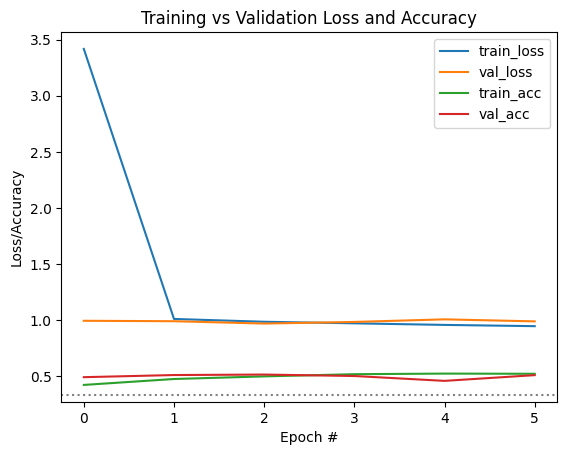

In [10]:
history_loss_accuracy(history, n_classes)

In [11]:
# Test scores
scores = xception_tl.evaluate(X_img_test, Y_test)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

61/61 [==============================] - 4s 59ms/step - loss: 0.9950 - accuracy: 0.4982
Test Loss: 0.9950
Test Accuracy: 0.4982


### 2.1.2. Fine-tuning

In [12]:
for layer in base_model.layers:
  if layer.name in ("block14_sepconv2 ", "block14_sepconv2_bn"):
    layer.trainable = True

# Create a new model on top
inputs = keras.Input(shape=(img_shape[0], img_shape[1], 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(n_classes, activation='softmax')(x)
xception_ft = Model(inputs, outputs)

xception_ft.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              33555456  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 54,420,011
Trainable params: 33,558,531
Non-t

In [13]:
# Compile the model
xception_ft.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-3),
                    metrics=['accuracy'])

# Set history early-stopping callbacks
history = History()
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=0,
                              mode='auto')

# Train the model on new data
xception_ft.fit(X_img_train,
                Y_train,
                batch_size=64,
                epochs=10,
                validation_data=(X_img_val, Y_val),
                callbacks=[history, earlystopping])

Epoch 1/10
102/102 [==============================] - 17s 142ms/step - loss: 3.0701 - accuracy: 0.4229 - val_loss: 1.0143 - val_accuracy: 0.4857
Epoch 2/10
102/102 [==============================] - 14s 133ms/step - loss: 1.0126 - accuracy: 0.4854 - val_loss: 0.9842 - val_accuracy: 0.4866
Epoch 3/10
102/102 [==============================] - 13s 125ms/step - loss: 0.9946 - accuracy: 0.5005 - val_loss: 0.9891 - val_accuracy: 0.4753
Epoch 4/10
102/102 [==============================] - 12s 122ms/step - loss: 0.9720 - accuracy: 0.5166 - val_loss: 0.9713 - val_accuracy: 0.4987
Epoch 5/10
102/102 [==============================] - 12s 121ms/step - loss: 0.9575 - accuracy: 0.5317 - val_loss: 0.9830 - val_accuracy: 0.5100
Epoch 6/10
102/102 [==============================] - 12s 120ms/step - loss: 0.9435 - accuracy: 0.5327 - val_loss: 0.9912 - val_accuracy: 0.4952
Epoch 7/10
102/102 [==============================] - 12s 120ms/step - loss: 0.9409 - accuracy: 0.5382 - val_loss: 0.9692 - val_ac

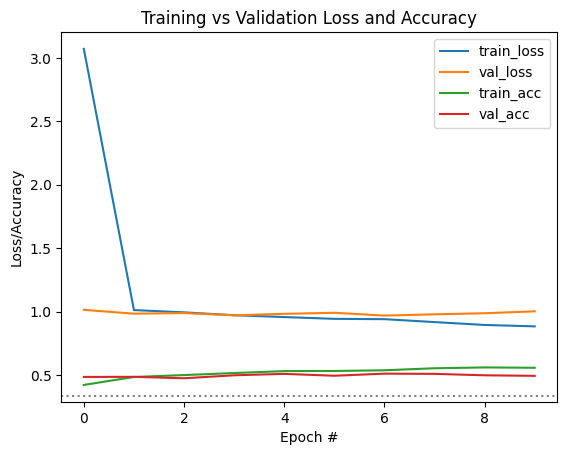

In [14]:
history_loss_accuracy(history, n_classes)

In [15]:
# Test scores
scores = xception_ft.evaluate(X_img_test, Y_test)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

61/61 [==============================] - 3s 49ms/step - loss: 1.0277 - accuracy: 0.4842
Test Loss: 1.0277
Test Accuracy: 0.4842


## 2.2. Fully connected neural network

In [16]:
from keras.layers import BatchNormalization, LeakyReLU

def classification_nn(input_shape, n_classes):
  ann = Sequential()
  ann.add(Dense(64,
                activation=LeakyReLU(alpha=0.05),
                kernel_initializer='normal',
                bias_initializer='ones',
                input_shape=input_shape))
  ann.add(Dropout(0.25))
  ann.add(BatchNormalization())
  ann.add(Dense(128,
                activation=LeakyReLU(alpha=0.05),
                kernel_initializer='normal',
                bias_initializer='ones'))
  ann.add(Dropout(0.25))
  ann.add(BatchNormalization())
  ann.add(Dense(128,
                activation=LeakyReLU(alpha=0.05),
                kernel_initializer='normal',
                bias_initializer='ones'))
  ann.add(Dropout(0.25))
  ann.add(BatchNormalization())
  ann.add(Dense(n_classes,
                activation='softmax',
                kernel_initializer='random_uniform'))

  return ann

In [17]:
ann = classification_nn((X_tab_train.shape[1],), n_classes)

# Compile the model
ann.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=1e-3),
            metrics=['accuracy'])

# Set history early-stopping callbacks
history = History()
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              verbose=0,
                              mode='auto')

# Train the model on new data
ann.fit(X_tab_train,
        Y_train,
        batch_size=32,
        shuffle=True,
        epochs=100,
        validation_data=(X_tab_val, Y_val),
        callbacks=[history, earlystopping])

Epoch 1/100
204/204 [==============================] - 3s 8ms/step - loss: 0.7693 - accuracy: 0.6428 - val_loss: 0.5896 - val_accuracy: 0.7654
Epoch 2/100
204/204 [==============================] - 1s 6ms/step - loss: 0.6573 - accuracy: 0.7181 - val_loss: 0.5930 - val_accuracy: 0.7680
Epoch 3/100
204/204 [==============================] - 1s 6ms/step - loss: 0.6361 - accuracy: 0.7271 - val_loss: 0.5693 - val_accuracy: 0.7610
Epoch 4/100
204/204 [==============================] - 1s 7ms/step - loss: 0.6191 - accuracy: 0.7383 - val_loss: 0.5625 - val_accuracy: 0.7662
Epoch 5/100
204/204 [==============================] - 1s 6ms/step - loss: 0.6211 - accuracy: 0.7399 - val_loss: 0.5632 - val_accuracy: 0.7723
Epoch 6/100
204/204 [==============================] - 1s 6ms/step - loss: 0.6141 - accuracy: 0.7434 - val_loss: 0.5631 - val_accuracy: 0.7680
Epoch 7/100
204/204 [==============================] - 2s 9ms/step - loss: 0.6098 - accuracy: 0.7468 - val_loss: 0.5657 - val_accuracy: 0.7506

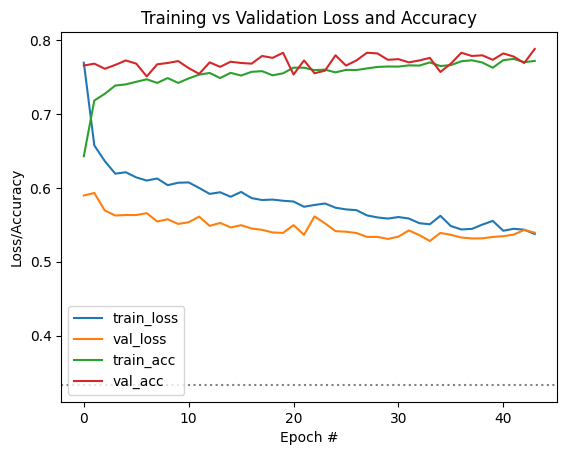

In [18]:
history_loss_accuracy(history, n_classes)

In [19]:
# Test scores
scores = ann.evaluate(X_tab_test, Y_test)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

61/61 [==============================] - 0s 3ms/step - loss: 0.5261 - accuracy: 0.7865
Test Loss: 0.5261
Test Accuracy: 0.7865


## 2.3. Fusion models

### 2.3.1. Early Fusion

In [20]:
from keras.layers import MaxPooling2D

base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(img_shape[0], img_shape[1], 3),
    include_top=False)

# Freeze base model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(img_shape[0], img_shape[1], 3))
x = base_model(inputs, training=False)
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Dropout(0.5)(x)
outputs = Flatten()(x)
model = Model(inputs, outputs)

In [21]:
X_features_train = model.predict(X_img_train)
X_features_val = model.predict(X_img_val)
X_features_test = model.predict(X_img_test)

X_train = tf.concat([X_features_train, X_tab_train], axis=1)
X_val = tf.concat([X_features_val, X_tab_val], axis=1)
X_test = tf.concat([X_features_test, X_tab_test], axis=1)

61/61 [==============================] - 3s 44ms/step


In [22]:
ann_earlyfusion = classification_nn((X_train.shape[1],), n_classes)

# Compile the model
ann_earlyfusion.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=1e-4),
                        metrics=['accuracy'])

# Set history early-stopping callbacks
history = History()
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              verbose=0,
                              mode='auto')

# Train the model on new data
ann_earlyfusion.fit(X_train,
                    Y_train,
                    batch_size=64,
                    shuffle=True,
                    epochs=100,
                    validation_data=(X_val, Y_val),
                    callbacks=[history, earlystopping])

Epoch 1/100
102/102 [==============================] - 4s 26ms/step - loss: 1.1023 - accuracy: 0.3781 - val_loss: 1.0599 - val_accuracy: 0.4260
Epoch 2/100
102/102 [==============================] - 2s 16ms/step - loss: 1.0278 - accuracy: 0.4707 - val_loss: 0.9605 - val_accuracy: 0.5299
Epoch 3/100
102/102 [==============================] - 1s 13ms/step - loss: 0.9597 - accuracy: 0.5201 - val_loss: 0.8787 - val_accuracy: 0.5853
Epoch 4/100
102/102 [==============================] - 1s 9ms/step - loss: 0.8917 - accuracy: 0.5652 - val_loss: 0.8135 - val_accuracy: 0.6165
Epoch 5/100
102/102 [==============================] - 1s 7ms/step - loss: 0.8282 - accuracy: 0.6015 - val_loss: 0.7657 - val_accuracy: 0.6390
Epoch 6/100
102/102 [==============================] - 1s 7ms/step - loss: 0.7806 - accuracy: 0.6273 - val_loss: 0.7417 - val_accuracy: 0.6502
Epoch 7/100
102/102 [==============================] - 1s 9ms/step - loss: 0.7394 - accuracy: 0.6525 - val_loss: 0.7160 - val_accuracy: 0.6

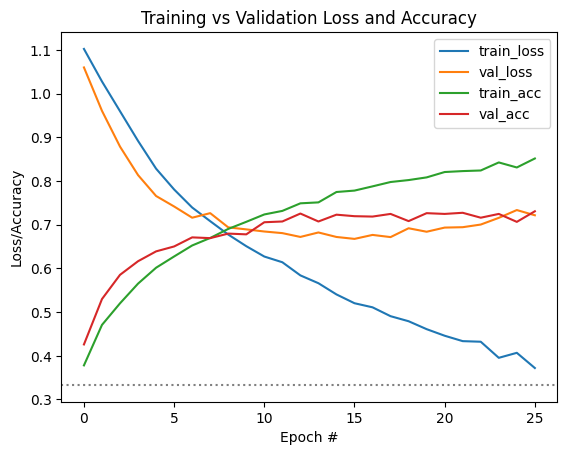

In [23]:
history_loss_accuracy(history, n_classes)

In [24]:
# Test scores
scores = ann_earlyfusion.evaluate(X_test, Y_test)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

61/61 [==============================] - 0s 3ms/step - loss: 0.7420 - accuracy: 0.7195
Test Loss: 0.7420
Test Accuracy: 0.7195


### 2.3.2. Late Fusion

In [25]:
X_train = tf.concat([xception_tl.predict(X_img_train), ann.predict(X_tab_train)], axis=1)
X_val = tf.concat([xception_tl.predict(X_img_val), ann.predict(X_tab_val)], axis=1)
X_test = tf.concat([xception_tl.predict(X_img_test), ann.predict(X_tab_test)], axis=1)

61/61 [==============================] - 0s 2ms/step


In [27]:
ann_latefusion = classification_nn((X_train.shape[1],), n_classes)

# Compile the model
ann_latefusion.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=1e-3),
                      metrics=['accuracy'])

# Set history early-stopping callbacks
history = History()
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              verbose=0,
                              mode='auto')

# Train the model on new data
ann_latefusion.fit(X_train,
                   Y_train,
                   batch_size=32,
                   shuffle=True,
                   epochs=100,
                   validation_data=(X_val, Y_val),
                   callbacks=[history, earlystopping])

Epoch 1/100
204/204 [==============================] - 5s 8ms/step - loss: 0.8415 - accuracy: 0.5819 - val_loss: 0.5516 - val_accuracy: 0.7784
Epoch 2/100
204/204 [==============================] - 1s 6ms/step - loss: 0.5640 - accuracy: 0.7729 - val_loss: 0.5558 - val_accuracy: 0.7896
Epoch 3/100
204/204 [==============================] - 3s 13ms/step - loss: 0.5280 - accuracy: 0.7959 - val_loss: 0.5756 - val_accuracy: 0.7714
Epoch 4/100
204/204 [==============================] - 2s 10ms/step - loss: 0.5223 - accuracy: 0.7905 - val_loss: 0.5465 - val_accuracy: 0.7775
Epoch 5/100
204/204 [==============================] - 2s 8ms/step - loss: 0.4994 - accuracy: 0.7966 - val_loss: 0.5437 - val_accuracy: 0.7844
Epoch 6/100
204/204 [==============================] - 1s 6ms/step - loss: 0.5020 - accuracy: 0.7920 - val_loss: 0.5491 - val_accuracy: 0.7870
Epoch 7/100
204/204 [==============================] - 1s 6ms/step - loss: 0.4912 - accuracy: 0.8018 - val_loss: 0.5491 - val_accuracy: 0.78

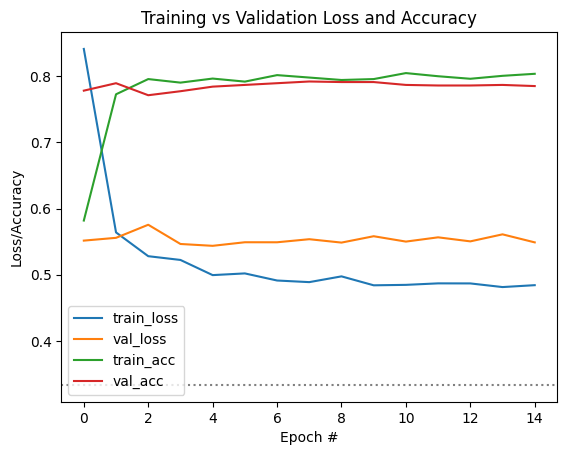

In [28]:
history_loss_accuracy(history, n_classes)

In [29]:
# Test scores
scores = ann_latefusion.evaluate(X_test, Y_test)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

61/61 [==============================] - 0s 3ms/step - loss: 0.5426 - accuracy: 0.7844
Test Loss: 0.5426
Test Accuracy: 0.7844


# **3. Conclusions**

- En la clasificación de imágenes se ha utilizado el modelo preentrenado Xception. Para el entrenamiento del modelo se han utilizado dos aproximaciones: transfer learning y fine-tuning. Aunque cabría esperar que el modelo entrenado con fine-tuning tuviera mejores prestaciones, los resultados en términos de accuracy en el conjunto de test han sido similares (49%).
- Para clasificar los datos tabulares se ha utilizado una red neuronal densa desarrollada desde cero, con un accuracy del 79% en el conjunto de test.
- En la fusión de modelos, el modelo de late fusion utilizado ha obtenido un accuracy similar al de la red neuronal densa (78%), mientras que el resultado del modelo de early fusion ha sido ligeramente inferior (71%), además de que en éste último se aprecia cierto overfitting a los datos de entrenamiento.
- Los resultados obtenidos con la CNN han sido discretos y, a pesar de que con la red neuronal densa la mejora ha sido significativa con la fusión de modelos no han mejorado las métricas.
- Las prestaciones de estos modelos son inferiores a las que se pueden obtener con [modelos basados en árboles de decisión](https://github.com/JCRbit/machine-learning-py/blob/main/machine_learning_airbnb.ipynb) pero la diferencia no es tan grande.